In [1]:
import findspark
findspark.init()
from pyspark import SparkContext

sc = SparkContext("local","quiz")

In [2]:
import math
import numpy as np

In [100]:
def create_dataset(N,D = 10, K=None):
	if K is None:
		K = math.ceil(math.sqrt(N)/2)

	def create_normal_dist(n):
		mu = np.random.randint(-100,100,size=(D,)) / 100. * D
		L = np.random.randint(-70,70,size=(D,D)) / 100.
		cov = np.dot(L,L.transpose())

		t = np.random.multivariate_normal(mu,cov,n)
		return t
	dataset = list()
	Csize = int(N/K)
	for _ in range(K):
		dataset_c = np.zeros((Csize,D+2))

		dataset_c[:,0] = np.arange(Csize,dtype='int')
		dataset_c[:,1:D+1] = create_normal_dist(Csize)
		dataset_c[:,D+1] = 1
		dataset.extend(dataset_c)
	# print(dataset)
	return np.array(dataset)

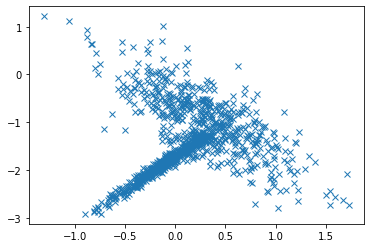

In [43]:
import matplotlib.pyplot as plt

ids,x1,y1 = create_dataset(1000,D=2,K=2).T
plt.plot(x1,y1,'x')

array([ 1.00000000e+02, -2.02949172e-02,  2.50171171e-01])

In [34]:
MAX_ITER = 50
CONVERGENCE_TOL = 0.001
K_LIST = [10,20,40,80]
DATA_SIZE_LIST = [1000,2000,4000,8000,16000]
DIMENSIONALITY = 10

In [27]:
def euclidean_dist(p1,p2):
	_sum = 0
	for i,_ in enumerate(p1):
		_sum += (p1[i] - p2[i]) ** 2

	return _sum ** 0.5

In [75]:
def closest_center(centers, point):
	closest = 0
	dist = 999999
	for i,c in enumerate(centers):
		temp = euclidean_dist(c,point)
		if  temp < dist:
			dist = temp
			closest = i

	return closest


In [112]:
import time
result = []

for data_size in DATA_SIZE_LIST:
	for k in K_LIST:
		start_time = time.time() 
		dataset = create_dataset(data_size,D=10,K=k)
		center = sc.broadcast([dataset[i][1:] for i in np.random.randint(0,data_size//k * k,k)])

		inputRDD = sc.parallelize(dataset).cache()

		for _ in range(MAX_ITER):
			key_value_pair = inputRDD.map(lambda x : (closest_center(center.value,x[1:]),x))
			after_reduce = key_value_pair.reduceByKey(lambda x,y : x+y).collect()
			after_reduce.sort(key=lambda x : x[0])
			# print(after_reduce)
			new_center = [ i[1][1:-1]/i[1][-1] for i in after_reduce ]
			
			eps = 0
			for i,_ in enumerate(new_center):
				eps += euclidean_dist(new_center[i],center.value[i])

			if eps <= CONVERGENCE_TOL:
				break
			
			center = sc.broadcast(new_center)
		
		result.append([data_size,k,time.time() - start_time])

		

In [113]:
result

[[1000, 10, 1.227241039276123],
 [1000, 20, 2.9980809688568115],
 [1000, 40, 3.26385498046875],
 [1000, 80, 11.748297214508057],
 [2000, 10, 2.6479811668395996],
 [2000, 20, 4.661335229873657],
 [2000, 40, 7.732882022857666],
 [2000, 80, 12.45121693611145],
 [4000, 10, 5.8717029094696045],
 [4000, 20, 9.929238080978394],
 [4000, 40, 23.0259850025177],
 [4000, 80, 30.24757695198059],
 [8000, 10, 11.431092023849487],
 [8000, 20, 37.44146275520325],
 [8000, 40, 61.02705907821655],
 [8000, 80, 83.89253973960876],
 [16000, 10, 50.616832971572876],
 [16000, 20, 91.4448139667511],
 [16000, 40, 116.97065806388855],
 [16000, 80, 306.8776478767395]]

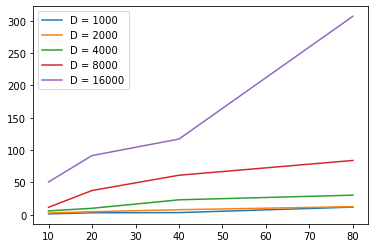

In [138]:


g1 = [i[2] for i in result[:4]]
g2 = [i[2] for i in result[4:8]]
g3 = [i[2] for i in result[8:12]]
g4 = [i[2] for i in result[12:16]]
g5 = [i[2] for i in result[16:20]]


plt.plot(K_LIST,g1,label = 'D = 1000')
plt.plot(K_LIST,g2,label = 'D = 2000')
plt.plot(K_LIST,g3,label = 'D = 4000')
plt.plot(K_LIST,g4,label = 'D = 8000')
plt.plot(K_LIST,g5,label = 'D = 16000')
plt.legend()

plt.show()